In [1]:
from datasets import load_dataset, load_metric
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras import Sequential, layers, regularizers
from keras.layers import Input, Dense,Conv2D , MaxPooling2D, Flatten,BatchNormalization,Dropout
import keras
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score , auc, plot_confusion_matrix
import tensorflow.keras.optimizers 
from tensorflow.keras.losses import CategoricalCrossentropy
import matplotlib.pyplot as plt
import keras.utils
import matplotlib as mpl
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
import matplotlib.pyplot as plt
import itertools
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import EfficientNetV2B0
from utils import *
from grad_cam import VizGradCAM
from tensorflow.keras.models import Model
import cv2


In [2]:
# data_dir = r"C:\Users\Jan\SGH\magisterka\dane\brain_tumor_mri_cropped"

In [3]:
data_dir = r"C:\Users\Jan\SGH\magisterka\dane\kvasir-dataset-v2\dane"

In [4]:
batch_size = 16
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    label_mode="categorical",
    seed=23,
    image_size= (img_height, img_width),
    batch_size=batch_size,
)


val_ds =  tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    label_mode="categorical",
    seed=23,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)


Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Found 8000 files belonging to 8 classes.
Using 1600 files for validation.


## Przegląd danych

In [5]:
# Extract class names
class_names = train_ds.class_names

# Count class instances in each dataset
train_class_counts = count_classes(train_ds, class_names)
val_class_counts = count_classes(val_ds, class_names)

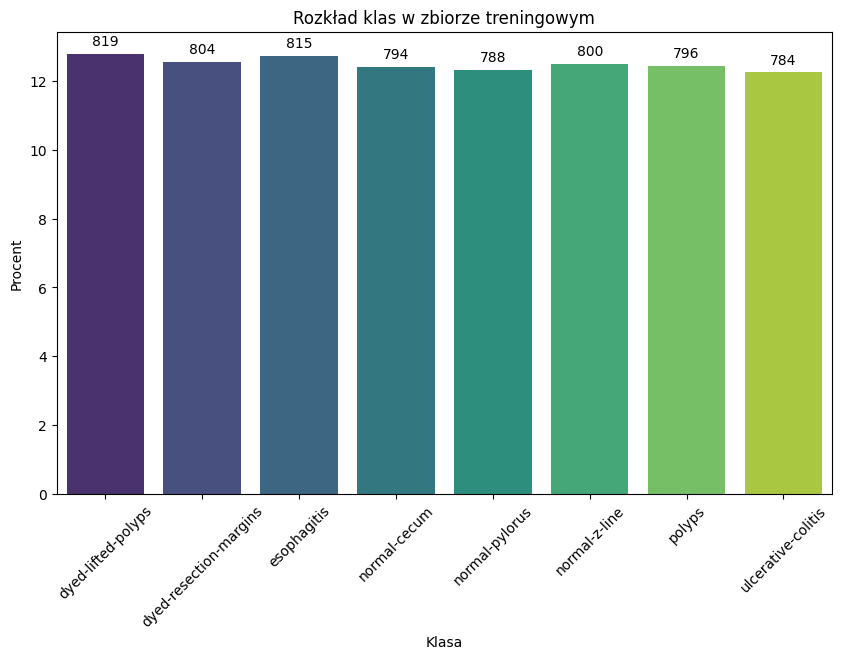

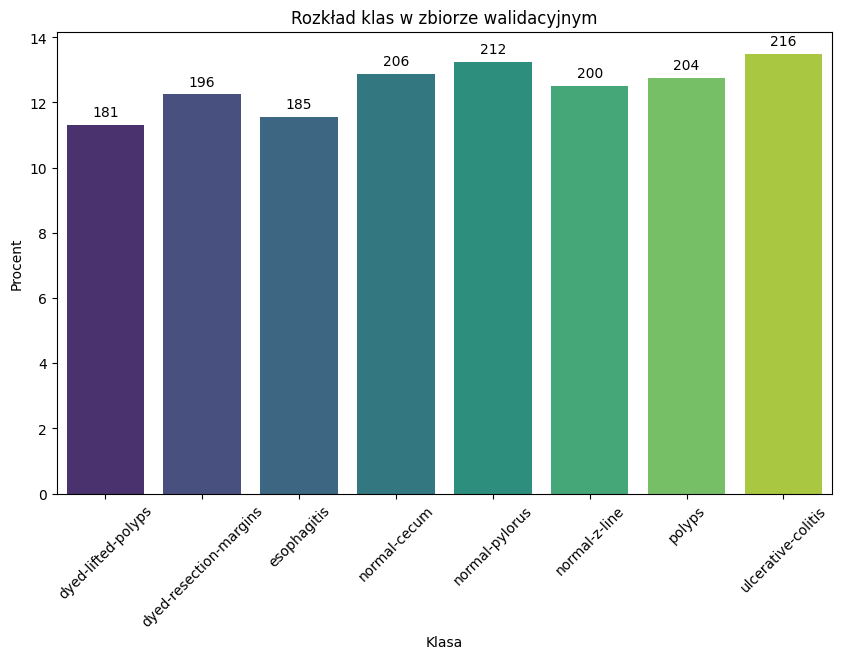

In [6]:
# Obliczenie całkowitej liczby instancji w każdym zbiorze
total_train_instances = sum(train_class_counts.values())
total_val_instances = sum(val_class_counts.values())
# Rysowanie wykresów
plot_class_distribution_seaborn(train_class_counts, 'Rozkład klas w zbiorze treningowym', total_train_instances)
plot_class_distribution_seaborn(val_class_counts, 'Rozkład klas w zbiorze walidacyjnym', total_val_instances)

In [7]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((val_batches) // 2)
val_ds = val_ds.skip((val_batches) // 2)

In [8]:
class_names = np.array(train_ds.class_names)
class_names

array(['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis',
       'normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps',
       'ulcerative-colitis'], dtype='<U22')

In [9]:
test_ds = test_ds.unbatch()
test_ds = test_ds.batch(1)

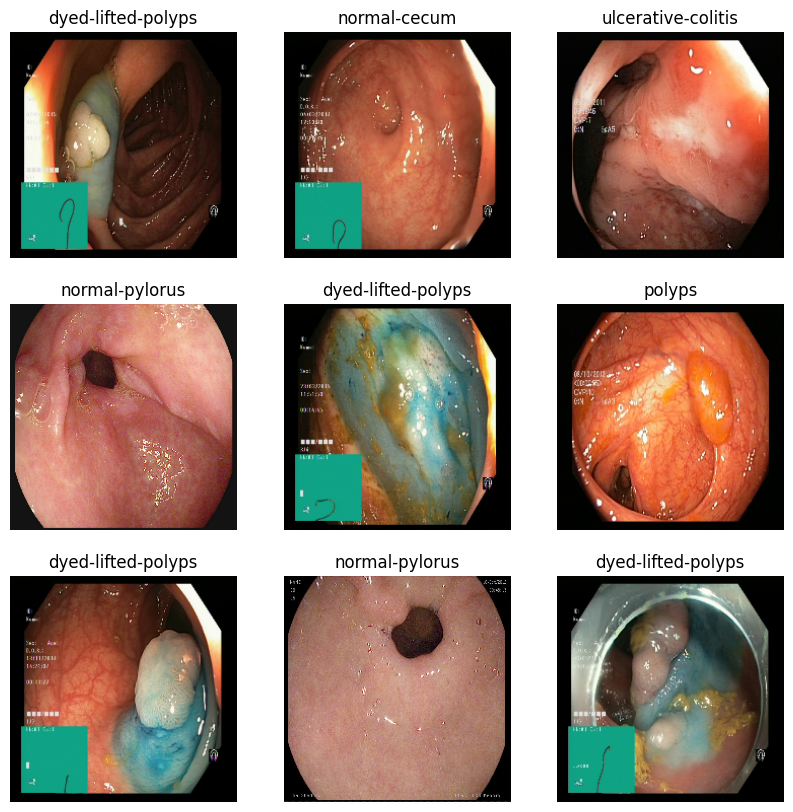

In [10]:
show_9_images_from_ds(train_ds, class_names)

In [11]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(10/360),
    layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
    layers.RandomContrast(factor=0.2),
]

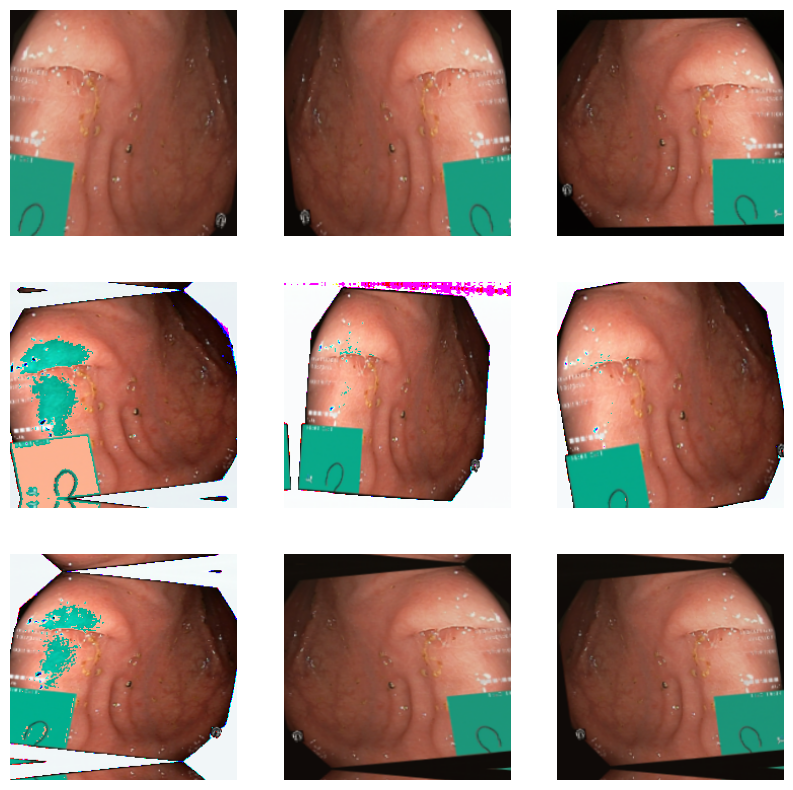

In [12]:
show_9_augmented_images(train_ds, data_augmentation_layers)

#### Normalizacja wartości piksela z przedziału [0,255] do [0,1]

In [13]:
rescale = Rescaling(scale=1.0/255)

In [14]:
rescale_layer = keras.Sequential(
    [
        layers.Rescaling(1.0 / 255), 
    ],
    name = "rescale"
)

#### Augmentacja danych zbioru uczącego

In [15]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img, data_augmentation_layers), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

#### Ustalam liczbę epok dla wszystkich moedli

In [16]:
epochs = 100

## Model pierwszy

In [ ]:
color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'orange'
color_map[ZeroPadding2D]['fill'] = 'gray'
color_map[Dropout]['fill'] = 'pink'
color_map[MaxPooling2D]['fill'] = 'red'
color_map[Dense]['fill'] = 'green'
color_map[Flatten]['fill'] = 'teal'
color_map[Rescaling]['fill'] = 'blue'
color_map[BatchNormalization]['fill'] = 'yellow'

In [17]:
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape = (224, 224, 3)),
    rescale,
    # Convolutional layers with batch normalization and max pooling
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding = 'same',input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding = 'same'),
    tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

In [18]:
model1.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8),
          loss=CategoricalCrossentropy(),
          metrics=['accuracy'])

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8,
                              patience=5, min_lr=1e-5)

best = keras.callbacks.ModelCheckpoint(filepath="training_weights/best/model1_best_val_accuracy.h5",
                                         save_weights_only=True,
                                         mointor="val_accuracy",
                                         mode="max",
                                         save_best_only=True)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',  patience=15, restore_best_weights=True)

history1 = model1.fit(
    train_ds,
    epochs= epochs,
    validation_data=val_ds,
    callbacks=[reduce_lr, best, early_stop]
)

Epoch 1/100
400/400 [==============================] - 19s 36ms/step - loss: 0.9987 - accuracy: 0.5642 - val_loss: 0.7364 - val_accuracy: 0.6725 - lr: 0.0010
Epoch 2/100
400/400 [==============================] - 14s 34ms/step - loss: 0.7363 - accuracy: 0.6606 - val_loss: 0.6493 - val_accuracy: 0.6888 - lr: 0.0010
Epoch 3/100
400/400 [==============================] - 14s 33ms/step - loss: 0.6762 - accuracy: 0.6942 - val_loss: 0.6562 - val_accuracy: 0.6812 - lr: 0.0010
Epoch 4/100
400/400 [==============================] - 14s 34ms/step - loss: 0.6722 - accuracy: 0.6878 - val_loss: 0.6933 - val_accuracy: 0.6825 - lr: 0.0010
Epoch 5/100
400/400 [==============================] - 14s 34ms/step - loss: 0.6217 - accuracy: 0.7122 - val_loss: 0.6493 - val_accuracy: 0.6750 - lr: 0.0010
Epoch 6/100
400/400 [==============================] - 15s 37ms/step - loss: 0.6168 - accuracy: 0.7191 - val_loss: 0.6806 - val_accuracy: 0.6637 - lr: 0.0010
Epoch 7/100
400/400 [==============================]

## Model drugi

In [19]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    rescale,
    
    tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.gelu, input_shape=(224, 224, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.gelu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.gelu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.gelu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(512, (3, 3), activation=tf.keras.activations.gelu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(1024, (3, 3), activation=tf.keras.activations.gelu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation=tf.keras.activations.gelu),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Dense(256, activation=tf.keras.activations.gelu),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

In [20]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 64)    

In [21]:
model2.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8),
          loss=CategoricalCrossentropy(),
          metrics=['accuracy'])

In [23]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.85,
                              patience=10, min_lr=1e-5)

best = keras.callbacks.ModelCheckpoint(filepath="training_weights/best/model2_best_val_accuracy.h5",
                                         save_weights_only=True,
                                         mointor="val_accuracy",
                                         mode="max",
                                         save_best_only=True)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history2 = model2.fit(
    train_ds,
    epochs= epochs,
    validation_data=val_ds,
    callbacks=[reduce_lr, best, early_stop]
)

Epoch 1/100
400/400 [==============================] - 15s 38ms/step - loss: 0.3956 - accuracy: 0.8402 - val_loss: 0.4556 - val_accuracy: 0.8163 - lr: 7.2250e-04
Epoch 2/100
400/400 [==============================] - 16s 38ms/step - loss: 0.3617 - accuracy: 0.8536 - val_loss: 0.5818 - val_accuracy: 0.7700 - lr: 7.2250e-04
Epoch 3/100
400/400 [==============================] - 16s 38ms/step - loss: 0.3445 - accuracy: 0.8642 - val_loss: 0.4714 - val_accuracy: 0.8288 - lr: 7.2250e-04
Epoch 4/100
400/400 [==============================] - 16s 38ms/step - loss: 0.3418 - accuracy: 0.8583 - val_loss: 0.4207 - val_accuracy: 0.8300 - lr: 7.2250e-04
Epoch 5/100
400/400 [==============================] - 16s 38ms/step - loss: 0.3317 - accuracy: 0.8698 - val_loss: 0.8390 - val_accuracy: 0.7487 - lr: 7.2250e-04
Epoch 6/100
400/400 [==============================] - 15s 37ms/step - loss: 0.3048 - accuracy: 0.8791 - val_loss: 0.4966 - val_accuracy: 0.8213 - lr: 7.2250e-04
Epoch 7/100
400/400 [=======

## Model trzeci

Dodano 2 warstwy dropoutoraz regularyzację

In [35]:
model3 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape = (224, 224, 3)),
    rescale,
    # Convolutional layers with batch normalization and max pooling
    tf.keras.layers.Conv2D(32, (3, 3), activation=None, input_shape=(224, 224, 3)),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation=None),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation=None),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(256, (3, 3), activation=None),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(512, (3, 3), activation=None, kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(1024, (3, 3), activation=None),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),

    # Flatten the output and add Dense layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(256),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.BatchNormalization(),

    # Output layer with 8 nodes for classification
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

In [36]:
model3.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8),
          loss=CategoricalCrossentropy(),
          metrics=['accuracy'])

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8,
                              patience=5, min_lr=1e-5)

best = keras.callbacks.ModelCheckpoint(filepath="training_weights/best/model3_best_val_accuracy.h5",
                                         save_weights_only=True,
                                         mointor="val_accuracy",
                                         mode="max",
                                         save_best_only=True)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',  patience=20, restore_best_weights=True)

history3 = model3.fit(
    train_ds,
    epochs= epochs,
    validation_data=val_ds,
    callbacks=[reduce_lr, best, early_stop]
)

Epoch 1/100
400/400 [==============================] - 15s 34ms/step - loss: 5.2607 - accuracy: 0.5311 - val_loss: 2.3579 - val_accuracy: 0.3325 - lr: 0.0010
Epoch 2/100
400/400 [==============================] - 14s 34ms/step - loss: 1.3218 - accuracy: 0.5661 - val_loss: 1.4235 - val_accuracy: 0.4663 - lr: 0.0010
Epoch 3/100
400/400 [==============================] - 14s 34ms/step - loss: 1.2267 - accuracy: 0.5848 - val_loss: 1.1423 - val_accuracy: 0.6050 - lr: 0.0010
Epoch 4/100
400/400 [==============================] - 14s 34ms/step - loss: 1.2181 - accuracy: 0.5825 - val_loss: 1.4447 - val_accuracy: 0.5900 - lr: 0.0010
Epoch 5/100
400/400 [==============================] - 14s 34ms/step - loss: 1.1818 - accuracy: 0.5889 - val_loss: 1.3657 - val_accuracy: 0.5325 - lr: 0.0010
Epoch 6/100
400/400 [==============================] - 14s 34ms/step - loss: 1.1592 - accuracy: 0.6116 - val_loss: 1.3598 - val_accuracy: 0.5225 - lr: 0.0010
Epoch 7/100
400/400 [==============================]

## Model czwarty - VGG16

In [37]:
model4 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape = (224, 224, 3)),
    rescale,
    # Convolutional layers with batch normalization and max pooling
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Flatten the output and add Dense layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(16),

    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

In [38]:
model4.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8),
          loss=CategoricalCrossentropy(),
          metrics=['accuracy'])

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8,
                              patience=5, min_lr=1e-5)

best = keras.callbacks.ModelCheckpoint(filepath="training_weights/best/model4_best_val_accuracy.h5",
                                         save_weights_only=True,
                                         mointor="val_accuracy",
                                         mode="max",
                                         save_best_only=True)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',  patience=20, restore_best_weights=True)

history4 = model4.fit(
    train_ds,
    epochs= epochs,
    validation_data=val_ds,
    callbacks=[reduce_lr, best, early_stop]
)

Epoch 1/100
400/400 [==============================] - 35s 82ms/step - loss: 27.0776 - accuracy: 0.3589 - val_loss: 23.0819 - val_accuracy: 0.2937 - lr: 0.0010
Epoch 2/100
400/400 [==============================] - 32s 79ms/step - loss: 4.0425 - accuracy: 0.4291 - val_loss: 1.0629 - val_accuracy: 0.5362 - lr: 0.0010
Epoch 3/100
400/400 [==============================] - 32s 79ms/step - loss: 1.7948 - accuracy: 0.5089 - val_loss: 6.5756 - val_accuracy: 0.2700 - lr: 0.0010
Epoch 4/100
400/400 [==============================] - 32s 79ms/step - loss: 3.3278 - accuracy: 0.4327 - val_loss: 1.3665 - val_accuracy: 0.4625 - lr: 0.0010
Epoch 5/100
400/400 [==============================] - 32s 79ms/step - loss: 1.9629 - accuracy: 0.4742 - val_loss: 1.1276 - val_accuracy: 0.5462 - lr: 0.0010
Epoch 6/100
400/400 [==============================] - 32s 79ms/step - loss: 2.4376 - accuracy: 0.4620 - val_loss: 1.1309 - val_accuracy: 0.4863 - lr: 0.0010
Epoch 7/100
400/400 [=============================

## Model piąty - Efficentnet_v2

In [39]:
base_efficientnet_v2_model = EfficientNetV2B0(include_top = False, 
                                             input_shape = (224, 224, 3),
                                             weights = 'imagenet')

In [40]:
base_efficientnet_v2_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_5[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  0           ['rescaling_2[0][0]']            
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 32  864         ['normalization[0

                                                                 ']                               
                                                                                                  
 block3b_project_bn (BatchNorma  (None, 28, 28, 48)  192         ['block3b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block3b_add (Add)              (None, 28, 28, 48)   0           ['block3b_project_bn[0][0]',     
                                                                  'block3a_project_bn[0][0]']     
                                                                                                  
 block4a_expand_conv (Conv2D)   (None, 28, 28, 192)  9216        ['block3b_add[0][0]']            
                                                                                                  
 block4a_e

                                                                                                  
 block4c_expand_activation (Act  (None, 14, 14, 384)  0          ['block4c_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block4c_dwconv2 (DepthwiseConv  (None, 14, 14, 384)  3456       ['block4c_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block4c_bn (BatchNormalization  (None, 14, 14, 384)  1536       ['block4c_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block4c_a

                                                                                                  
 block5b_se_squeeze (GlobalAver  (None, 672)         0           ['block5b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5b_se_reshape (Reshape)   (None, 1, 1, 672)    0           ['block5b_se_squeeze[0][0]']     
                                                                                                  
 block5b_se_reduce (Conv2D)     (None, 1, 1, 28)     18844       ['block5b_se_reshape[0][0]']     
                                                                                                  
 block5b_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block5b_se_reduce[0][0]']      
                                                                                                  
 block5b_s

                                                                                                  
 block5d_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5d_activation[0][0]',     
                                                                  'block5d_se_expand[0][0]']      
                                                                                                  
 block5d_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5d_se_excite[0][0]']      
                                                                                                  
 block5d_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5d_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5d_add (Add)              (None, 14, 14, 112)  0           ['block5d_project_bn[0][0]',     
          

 block6b_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6a_project_bn[0][0]']     
                                                                                                  
 block6b_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block6b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6b_expand_activation (Act  (None, 7, 7, 1152)  0           ['block6b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6b_dwconv2 (DepthwiseConv  (None, 7, 7, 1152)  10368       ['block6b_expand_activation[0][0]
 2D)                                                             ']                               
          

 2D)                                                             ']                               
                                                                                                  
 block6d_bn (BatchNormalization  (None, 7, 7, 1152)  4608        ['block6d_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block6d_activation (Activation  (None, 7, 7, 1152)  0           ['block6d_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6d_se_squeeze (GlobalAver  (None, 1152)        0           ['block6d_activation[0][0]']     
 agePooling2D)                                                                                    
          

 agePooling2D)                                                                                    
                                                                                                  
 block6f_se_reshape (Reshape)   (None, 1, 1, 1152)   0           ['block6f_se_squeeze[0][0]']     
                                                                                                  
 block6f_se_reduce (Conv2D)     (None, 1, 1, 48)     55344       ['block6f_se_reshape[0][0]']     
                                                                                                  
 block6f_se_expand (Conv2D)     (None, 1, 1, 1152)   56448       ['block6f_se_reduce[0][0]']      
                                                                                                  
 block6f_se_excite (Multiply)   (None, 7, 7, 1152)   0           ['block6f_activation[0][0]',     
                                                                  'block6f_se_expand[0][0]']      
          

                                                                  'block6h_se_expand[0][0]']      
                                                                                                  
 block6h_project_conv (Conv2D)  (None, 7, 7, 192)    221184      ['block6h_se_excite[0][0]']      
                                                                                                  
 block6h_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block6h_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6h_add (Add)              (None, 7, 7, 192)    0           ['block6h_project_bn[0][0]',     
                                                                  'block6g_add[0][0]']            
                                                                                                  
 top_conv 

In [41]:
base_efficientnet_v2_model.layers[1].scale == 1/255

True

In [42]:
base_efficientnet_v2_model.trainable = True
print(len(base_efficientnet_v2_model.layers))

255


In [47]:
model5 = base_efficientnet_v2_model.output
model5 = tf.keras.layers.GlobalAveragePooling2D()(model5)
model5 = tf.keras.layers.Dropout(0.5)(model5)
model5 = tf.keras.layers.Dense(len(class_names), activation='softmax')(model5)
model5 = Model(inputs=base_efficientnet_v2_model.input,
              outputs=model5)

In [49]:
model5.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_5[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  0           ['rescaling_2[0][0]']            
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 32  864         ['normalization[0][0]']    

                                                                 ']                               
                                                                                                  
 block3b_project_bn (BatchNorma  (None, 28, 28, 48)  192         ['block3b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block3b_add (Add)              (None, 28, 28, 48)   0           ['block3b_project_bn[0][0]',     
                                                                  'block3a_project_bn[0][0]']     
                                                                                                  
 block4a_expand_conv (Conv2D)   (None, 28, 28, 192)  9216        ['block3b_add[0][0]']            
                                                                                                  
 block4a_e

                                                                                                  
 block4c_expand_activation (Act  (None, 14, 14, 384)  0          ['block4c_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block4c_dwconv2 (DepthwiseConv  (None, 14, 14, 384)  3456       ['block4c_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block4c_bn (BatchNormalization  (None, 14, 14, 384)  1536       ['block4c_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block4c_a

                                                                                                  
 block5b_se_squeeze (GlobalAver  (None, 672)         0           ['block5b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5b_se_reshape (Reshape)   (None, 1, 1, 672)    0           ['block5b_se_squeeze[0][0]']     
                                                                                                  
 block5b_se_reduce (Conv2D)     (None, 1, 1, 28)     18844       ['block5b_se_reshape[0][0]']     
                                                                                                  
 block5b_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block5b_se_reduce[0][0]']      
                                                                                                  
 block5b_s

                                                                                                  
 block5d_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5d_activation[0][0]',     
                                                                  'block5d_se_expand[0][0]']      
                                                                                                  
 block5d_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5d_se_excite[0][0]']      
                                                                                                  
 block5d_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5d_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5d_add (Add)              (None, 14, 14, 112)  0           ['block5d_project_bn[0][0]',     
          

 block6b_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6a_project_bn[0][0]']     
                                                                                                  
 block6b_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block6b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6b_expand_activation (Act  (None, 7, 7, 1152)  0           ['block6b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6b_dwconv2 (DepthwiseConv  (None, 7, 7, 1152)  10368       ['block6b_expand_activation[0][0]
 2D)                                                             ']                               
          

 2D)                                                             ']                               
                                                                                                  
 block6d_bn (BatchNormalization  (None, 7, 7, 1152)  4608        ['block6d_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block6d_activation (Activation  (None, 7, 7, 1152)  0           ['block6d_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6d_se_squeeze (GlobalAver  (None, 1152)        0           ['block6d_activation[0][0]']     
 agePooling2D)                                                                                    
          

 agePooling2D)                                                                                    
                                                                                                  
 block6f_se_reshape (Reshape)   (None, 1, 1, 1152)   0           ['block6f_se_squeeze[0][0]']     
                                                                                                  
 block6f_se_reduce (Conv2D)     (None, 1, 1, 48)     55344       ['block6f_se_reshape[0][0]']     
                                                                                                  
 block6f_se_expand (Conv2D)     (None, 1, 1, 1152)   56448       ['block6f_se_reduce[0][0]']      
                                                                                                  
 block6f_se_excite (Multiply)   (None, 7, 7, 1152)   0           ['block6f_activation[0][0]',     
                                                                  'block6f_se_expand[0][0]']      
          

                                                                  'block6h_se_expand[0][0]']      
                                                                                                  
 block6h_project_conv (Conv2D)  (None, 7, 7, 192)    221184      ['block6h_se_excite[0][0]']      
                                                                                                  
 block6h_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block6h_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6h_add (Add)              (None, 7, 7, 192)    0           ['block6h_project_bn[0][0]',     
                                                                  'block6g_add[0][0]']            
                                                                                                  
 top_conv 

In [50]:
model5.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8),
          loss=CategoricalCrossentropy(),
          metrics=['accuracy'])

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8,
                              patience=5, min_lr=1e-5)

best = keras.callbacks.ModelCheckpoint(filepath="training_weights/best/model5_best_val_accuracy.h5",
                                         save_weights_only=True,
                                         mointor="val_accuracy",
                                         mode="max",
                                         save_best_only=True)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',  patience=20, restore_best_weights=True)

history5 = model5.fit(
    train_ds,
    epochs= epochs,
    validation_data=val_ds,
    callbacks=[reduce_lr, best, early_stop]
)

Epoch 1/100
400/400 [==============================] - 31s 62ms/step - loss: 0.5479 - accuracy: 0.7947 - val_loss: 0.3598 - val_accuracy: 0.8587 - lr: 0.0010
Epoch 2/100
400/400 [==============================] - 25s 61ms/step - loss: 0.3353 - accuracy: 0.8759 - val_loss: 0.2932 - val_accuracy: 0.8988 - lr: 0.0010
Epoch 3/100
400/400 [==============================] - 24s 59ms/step - loss: 0.2844 - accuracy: 0.8883 - val_loss: 0.2480 - val_accuracy: 0.9050 - lr: 0.0010
Epoch 4/100
400/400 [==============================] - 23s 58ms/step - loss: 0.2487 - accuracy: 0.9042 - val_loss: 0.3025 - val_accuracy: 0.8938 - lr: 0.0010
Epoch 5/100
400/400 [==============================] - 24s 59ms/step - loss: 0.2236 - accuracy: 0.9159 - val_loss: 0.2754 - val_accuracy: 0.8925 - lr: 0.0010
Epoch 6/100
400/400 [==============================] - 24s 58ms/step - loss: 0.2135 - accuracy: 0.9186 - val_loss: 0.2861 - val_accuracy: 0.9038 - lr: 0.0010
Epoch 7/100
400/400 [==============================]

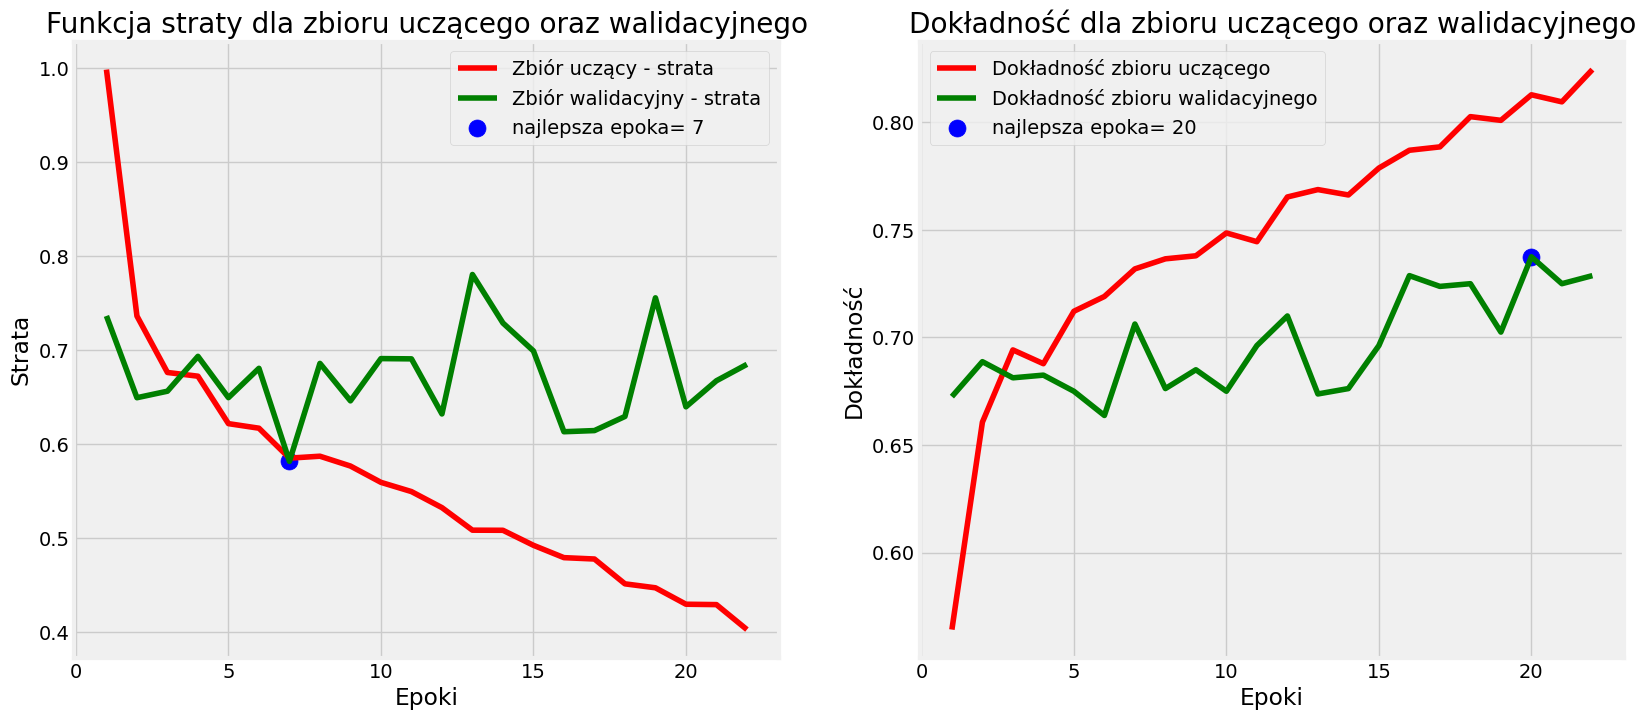

In [63]:
show_loss_accuracy_plots(history1)

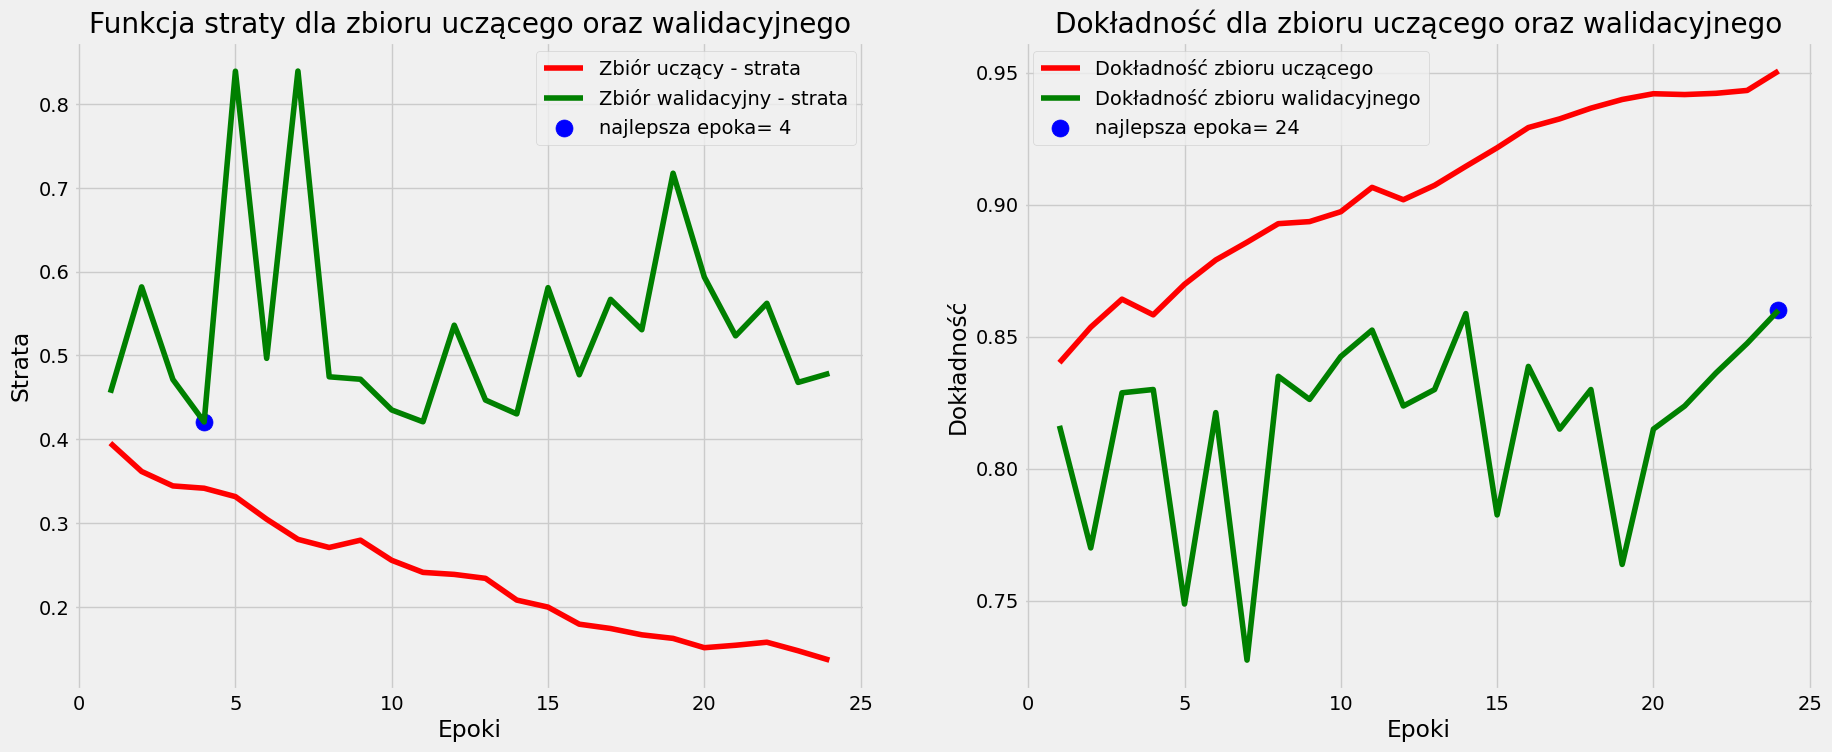

In [64]:
show_loss_accuracy_plots(history2)

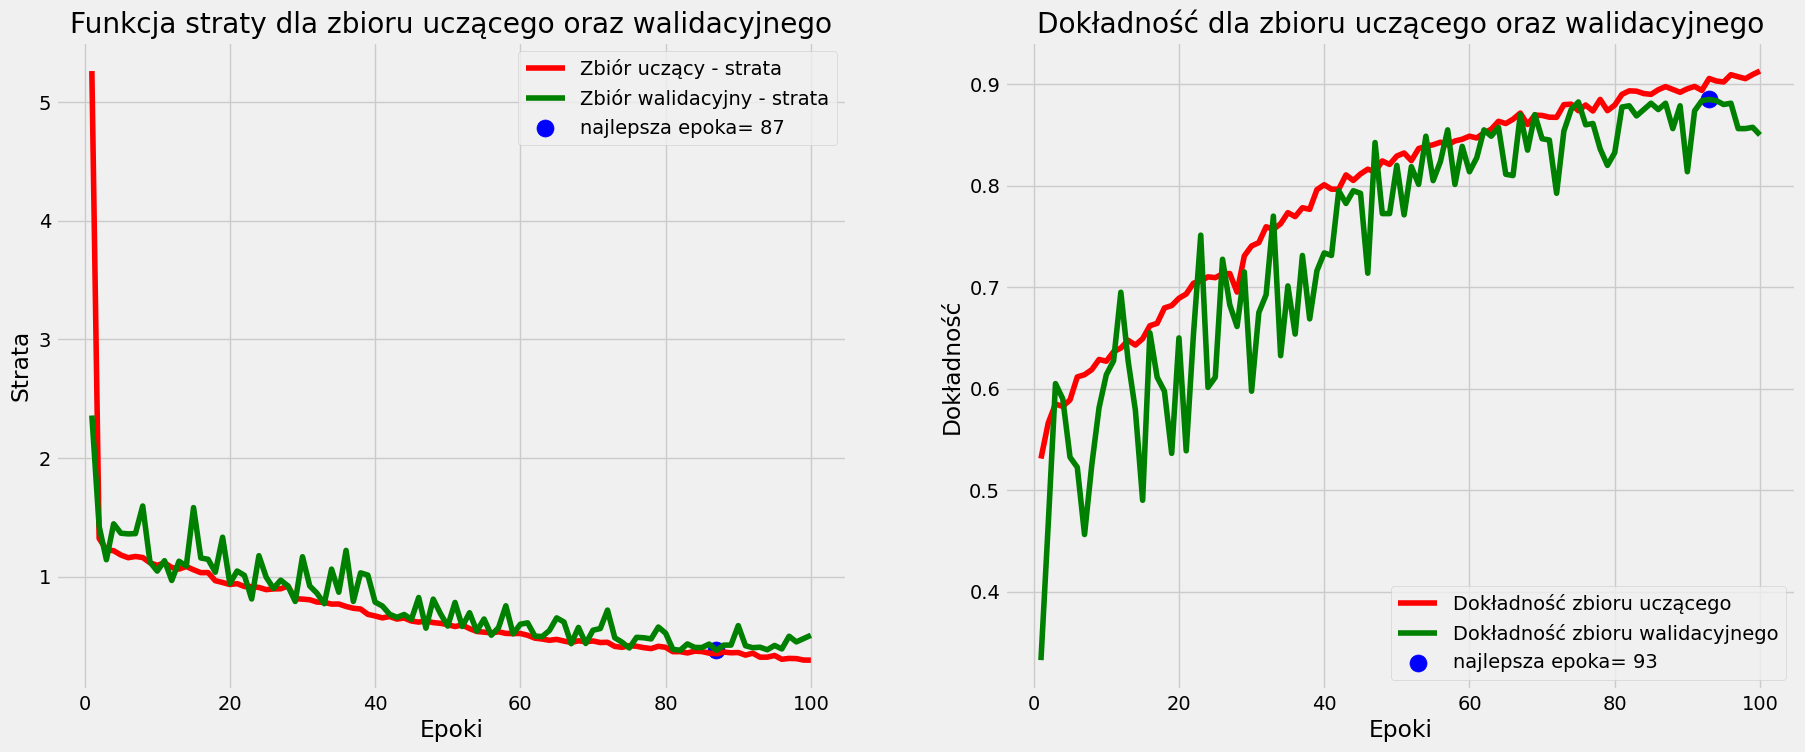

In [65]:
show_loss_accuracy_plots(history3)

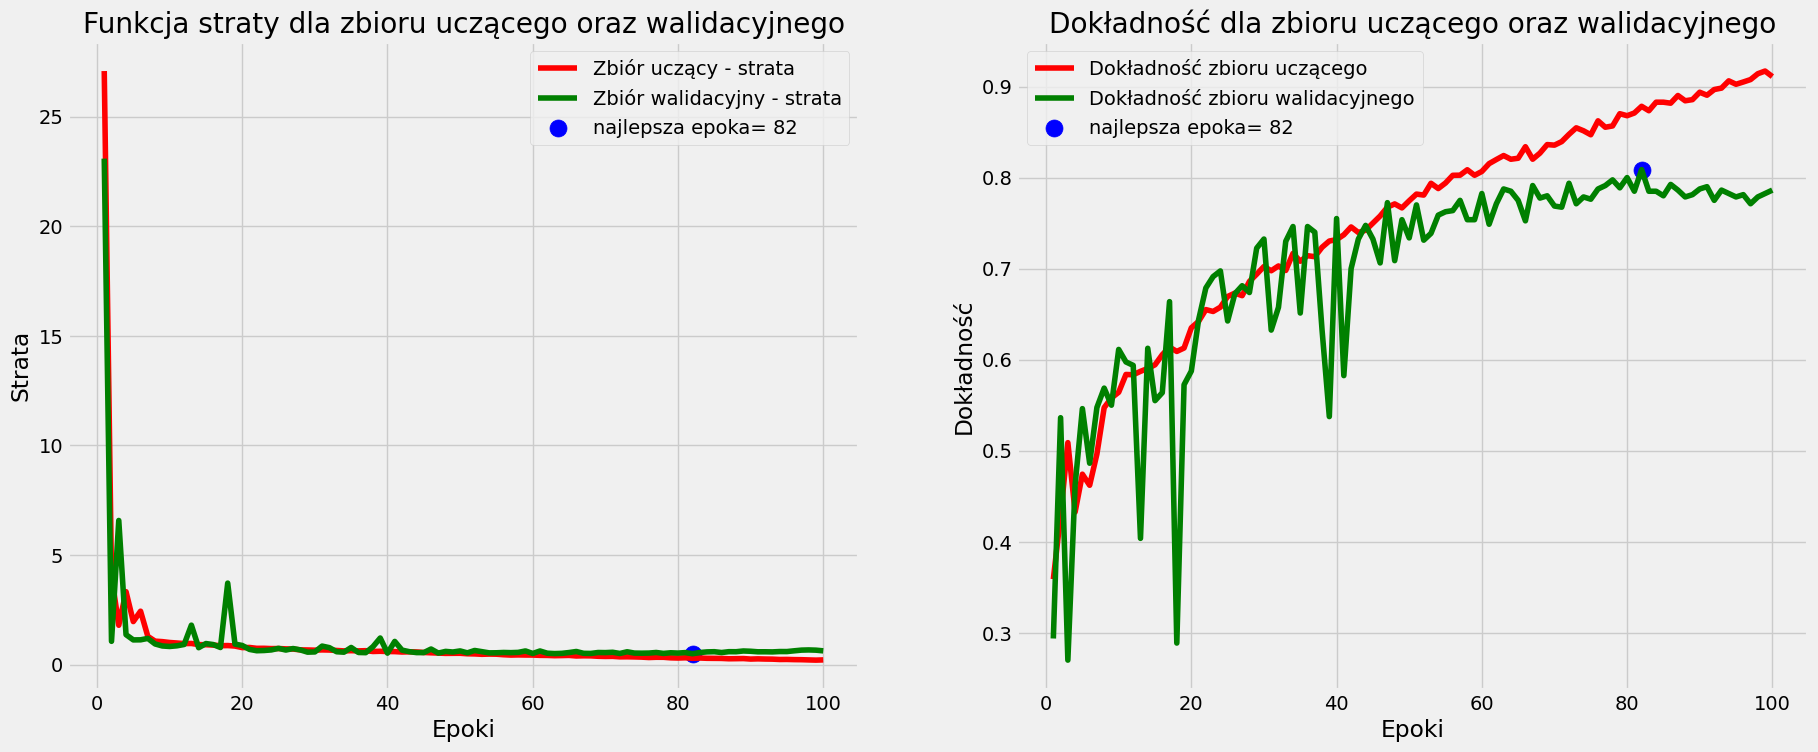

In [66]:
show_loss_accuracy_plots(history4)

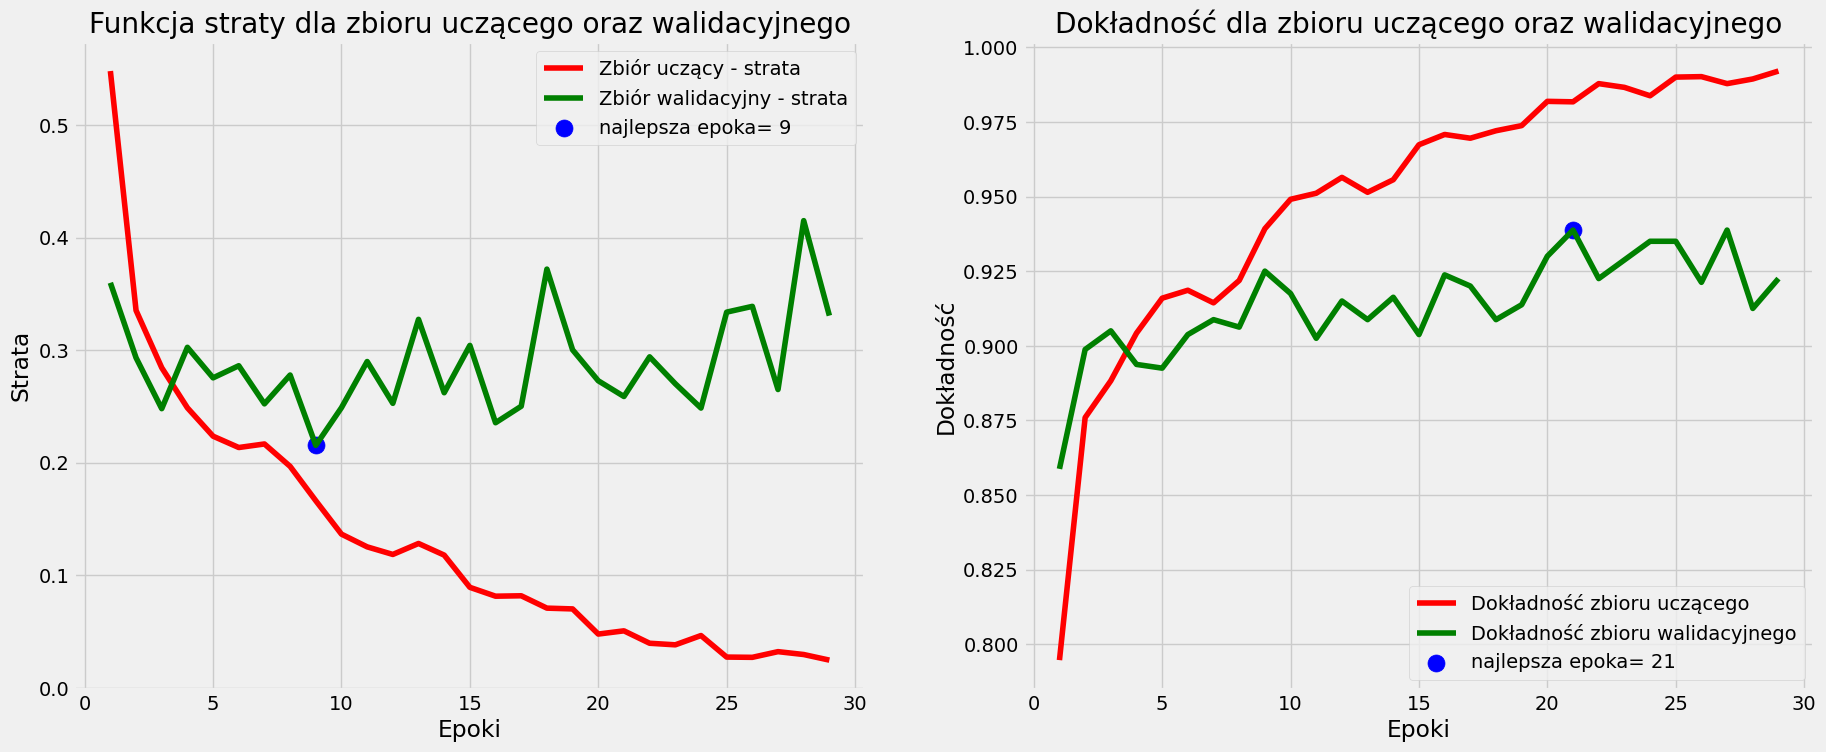

In [67]:
show_loss_accuracy_plots(history5)

## Ewaluacja i porównanie modeli

In [52]:
models = {
    'model1': model1,
    'model2': model2,
    'model3': model3,
    'model4': model4,
    'model5': model5,
}

In [53]:
best_models = find_best_model(models, test_ds)
for metric, (model_name, score) in best_models.items():
    print(f"Najlepszy model dla {metric}: {model_name} z wynikiem {score}")

Raport klasyfikacji dla model1:
              precision    recall  f1-score   support

           0       0.53      0.86      0.66        93
           1       0.70      0.32      0.43        95
           2       0.68      0.71      0.70        92
           3       0.82      0.84      0.83        98
           4       0.98      0.87      0.92        91
           5       0.73      0.79      0.76       118
           6       0.62      0.70      0.66       105
           7       0.81      0.63      0.71       108

    accuracy                           0.71       800
   macro avg       0.73      0.71      0.71       800
weighted avg       0.73      0.71      0.71       800

Raport klasyfikacji dla model2:
              precision    recall  f1-score   support

           0       0.82      0.72      0.77        96
           1       0.73      0.87      0.79        97
           2       0.74      0.69      0.72        88
           3       0.83      0.96      0.89       100
           4  

In [ ]:
# model1.load_weights("training_weights/best/model1_best_val_accuracy.h5")
# model2.load_weights("training_weights/best/model2_best_val_accuracy.h5")
# model3.load_weights("training_weights/best/model3_best_val_accuracy.h5")
# model4.load_weights("training_weights/best/model4_best_val_accuracy.h5")
# model5.load_weights("training_weights/best/model6_best_val_accuracy.h5")

### Macierz pomyłek

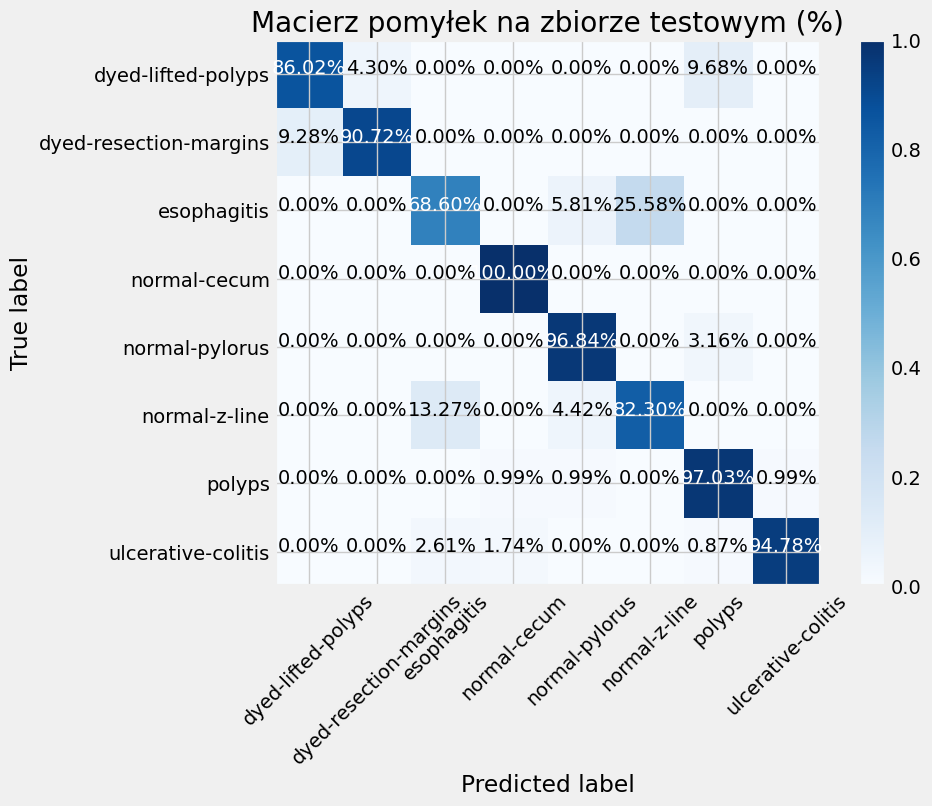

In [70]:
test_predictions, test_labels = get_predictions_and_labels(model5, test_ds)
cm_test = confusion_matrix(np.argmax(test_labels, axis=1), test_predictions)
plot_confusion_matrix_percent(cm_test, class_names, 'Macierz pomyłek na zbiorze testowym (%)')

### Grad cam

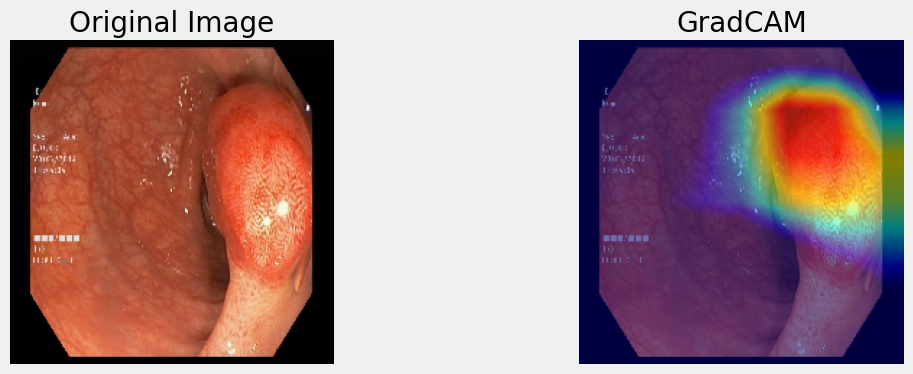

In [84]:
test_img = img_to_array(load_img(r"C:\Users\Jan\SGH\magisterka\dane\kvasir-dataset-v2\dane\polyps\0a98bcca-3046-4d9f-adf7-301ef4897e7a.jpg" , target_size=(224,224)))

VizGradCAM(model5, test_img)
# 30, 147 

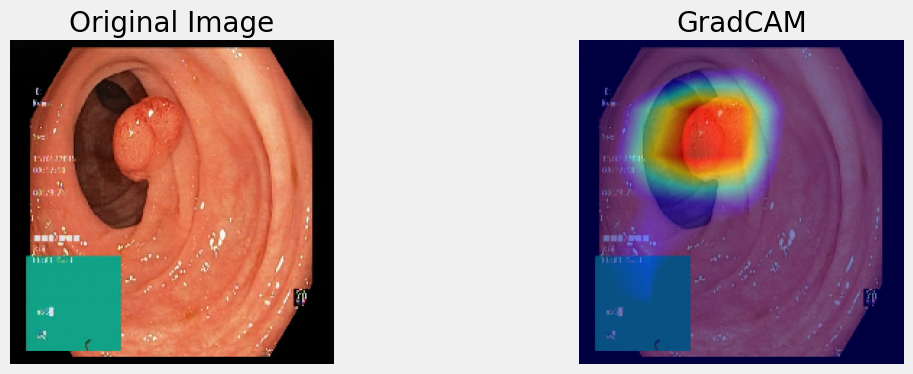

In [81]:
test_img = img_to_array(load_img(r"C:\Users\Jan\SGH\magisterka\dane\kvasir-dataset-v2\dane\polyps\0b4a70c1-aa5e-467c-9b60-dda2c4cb1315.jpg" , target_size=(224,224)))

VizGradCAM(model5, test_img)
# 30, 147 

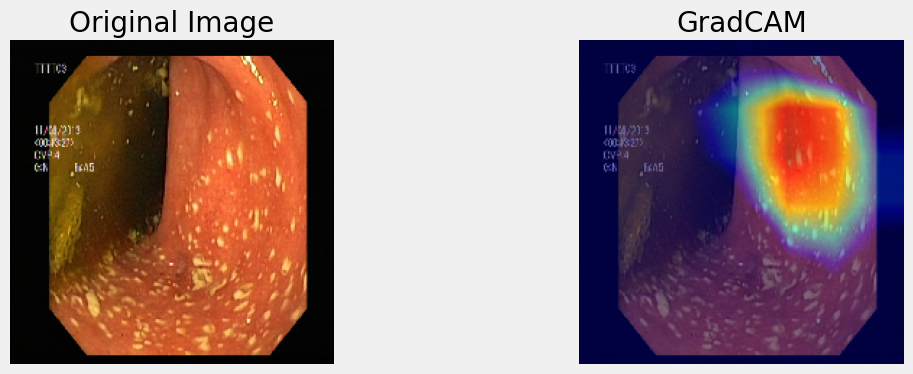

In [85]:
test_img = img_to_array(load_img(r"C:\Users\Jan\SGH\magisterka\dane\kvasir-dataset-v2\dane\ulcerative-colitis\1fc2ebce-9831-4355-8330-2b4cc4b11b17.jpg" , target_size=(224,224)))

VizGradCAM(model5, test_img)

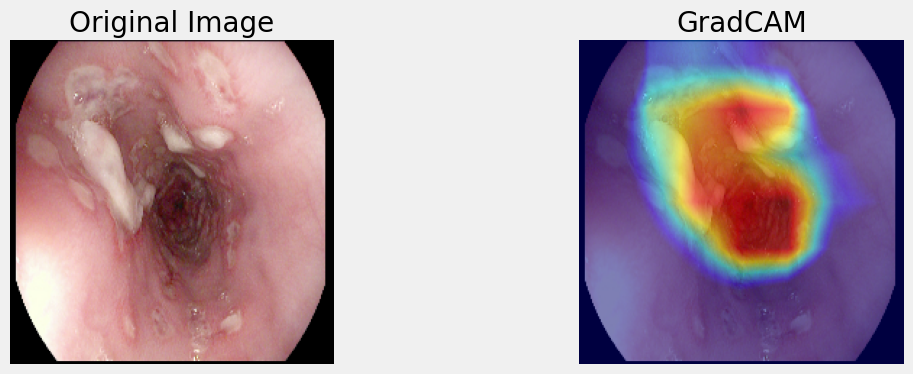

In [86]:
test_img = img_to_array(load_img(r"C:\Users\Jan\SGH\magisterka\dane\kvasir-dataset-v2\dane\esophagitis\001fb927-4814-4ba5-851d-189db99291d8.jpg" , target_size=(224,224)))

VizGradCAM(model5, test_img)